In [1]:
import warnings
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

D:\program Data\anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 数据基本情况

In [2]:
# 导入数据  观察数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

#固定模块可视化数值间的关系
pandas_profiling.ProfileReport(train_data).to_file('./example.html')
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


### 正态化目标值

SalePrice是最后预测的数据

In [3]:
train_data['SalePrice'].skew()

1.8828757597682129

之前房价的偏度是1.88，很多模型的隐含假设都是normal，一般归一化后效果比较理想，所以这里正态化

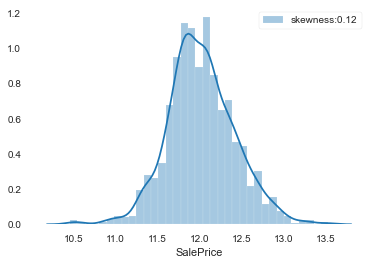

In [4]:
# log正态
train_data['SalePrice'] = np.log(train_data['SalePrice'])

sns.distplot(train_data['SalePrice'][train_data['SalePrice'].notnull()],
             label='skewness:%.2f' % (train_data['SalePrice'].skew())).legend(loc='best')

# 1、数据清洗

对合并前的train数据集进行异常值处理

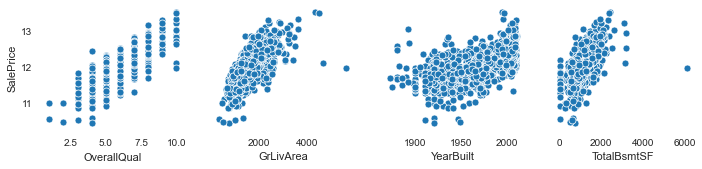

In [5]:
# 装修质量，居住面积，建造年限，地下室面积与售价关系
sns.pairplot(x_vars=['OverallQual', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF'], y_vars=['SalePrice'], data=train_data,
             dropna=True)
# 去除离群点，异常点
train_data.drop(train_data[(train_data['OverallQual'] < 5) & (train_data['SalePrice'] > 200000)].index, inplace=True)
train_data.drop(train_data[(train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 300000)].index, inplace=True)
train_data.reset_index(drop=True, inplace=True)  # 引索重制

合并训练数据、测试数据

In [8]:
df = train_data.append(test_data, ignore_index=True)
## 删除Id,SalePrice列
df.drop(['Id'], axis=1, inplace=True)
df.drop(['SalePrice'], axis=1, inplace=True)
df.shape

(2915, 79)

缺失值处理

In [9]:
# 查看缺失值
df.isnull().sum().sort_values(ascending=False)

PoolQC         2907
MiscFeature    2810
Alley          2717
Fence          2345
FireplaceQu    1420
               ... 
1stFlrSF          0
CentralAir        0
Heating           0
Foundation        0
MSSubClass        0
Length: 79, dtype: int64

In [10]:
# 影响较小且缺失数量多的，None填充
cols1 = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageQual', 'GarageCond', 'GarageFinish',
         'GarageYrBlt', 'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
         'MasVnrType']
for col in cols1:
    df[col].fillna('None', inplace=True)
# 房屋无配置物品，用0填充
cols2 = ['BsmtUnfSF', 'TotalBsmtSF', 'BsmtFinSF2', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtHalfBath', \
         'MasVnrArea', 'GarageCars', 'GarageArea', 'GarageYrBlt']
for col in cols2:
    df[col].fillna(0, inplace=True)
# 缺失值的数量较少，用众数填充
cols3 = ['MSZoning', 'BsmtFullBath', 'BsmtHalfBath', 'Utilities', 'Functional', 'Electrical', 'KitchenQual', 'SaleType',
         'Exterior1st', 'Exterior2nd']
for col in cols3:
    df[col].fillna(df[col].mode()[0], inplace=True)
    
# 根据地皮面积LotArea和市区位置Neighborhood的中位数来估算到街道距离LotFrontage的缺失值。
df['LotAreaCut'] = pd.qcut(df.LotArea, 10)  ## 由于LotArea是连续的数据，因此将(1299.999,215245.0]分为10个部分。

df.groupby('Neighborhood')[['LotFrontage']].agg(['mean', 'median', 'count'])
df.groupby('LotAreaCut')[['LotFrontage']].agg(['mean', 'median', 'count'])

df['LotFrontage'] = df.groupby(['LotAreaCut', 'Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df['LotFrontage'] = df.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df.drop(['LotAreaCut'], axis=1, inplace=True)
# 统计是否还有缺失值
df.isnull().sum().sort_values()
df.info()
del col,cols1,cols2,cols3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2915 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2915 non-null   float64
 3   LotArea        2915 non-null   int64  
 4   Street         2915 non-null   object 
 5   Alley          2915 non-null   object 
 6   LotShape       2915 non-null   object 
 7   LandContour    2915 non-null   object 
 8   Utilities      2915 non-null   object 
 9   LotConfig      2915 non-null   object 
 10  LandSlope      2915 non-null   object 
 11  Neighborhood   2915 non-null   object 
 12  Condition1     2915 non-null   object 
 13  Condition2     2915 non-null   object 
 14  BldgType       2915 non-null   object 
 15  HouseStyle     2915 non-null   object 
 16  OverallQual    2915 non-null   int64  
 17  OverallCond    2915 non-null   int64  
 18  YearBuil

# 2、特征工程

## 2.1对值进行编码

进行编码之后特征变成了91个

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder  # 标签编码
from sklearn.preprocessing import RobustScaler, StandardScaler  # 缩放异常值与数据标准化
from scipy.stats import skew  # 偏度
from sklearn.linear_model import Lasso  # 分类关系排行
from sklearn.decomposition import PCA, KernelPCA

#观察数据，部分数字并没有顺序关系，仅仅只是个标签，将这部分数据转换为字符

# 离散型数据，转换为字符
NumtoStr = ['MSSubClass', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'MoSold', 'YrSold', 'YearBuilt', 'YearRemodAdd', 'LowQualFinSF', 'GarageYrBlt']
for col in NumtoStr:
    df[col] = df[col].astype(str)

# 年份编码
str_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', "YrSold", 'MoSold']
for col in str_cols:
    df[col] = LabelEncoder().fit_transform(df[col])


In [12]:
#对明确有顺序、大小之分的值进行编码
def order_coding(x):
    order = ['Po', 'None', 'Fa', 'TA', 'Gd', 'Ex']
    keys = list(set(x))
    order_key = []
    for i in order:
        for j in keys:
            if j.find(i) > -1:
                order_key.append(j)
    what = dict(zip(order_key, range(1, 7)))
    return x.map(what)

cols = ['BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 'GarageCond', 'GarageQual', 'HeatingQC','KitchenQual', 'PoolQC']
for col in cols:
    n_col = 'n' + col
    df[n_col] = order_coding(df[col])

del col,order_coding,NumtoStr,str_cols,cols


In [13]:
#对其他有意义的标签编码（建筑等级‘MSSubClass’，主要交通的便利程度‘Condition’）
# 建筑等级
df['nMSSubClass'] = df.MSSubClass.map({'180': 1,
                                       '30': 2, '45': 2,
                                       '190': 3, '50': 3, '90': 3,
                                       '85': 4, '40': 4, '160': 4,
                                       '70': 5, '20': 5, '75': 5, '80': 5, '150': 5,
                                       '120': 6, '60': 6})
# 主干道便利程度
df['nCondition1'] = df.Condition1.map({'Artery': 1,
                                       'Feedr': 2, 'RRAe': 2,
                                        'Norm': 3, 'RRAn': 3,
                                       'PosN': 4, 'RRNe': 4,
                                       'PosA': 5, 'RRNn': 5})


In [14]:
df.shape

(2915, 91)

## 2.2特征重要程度

先对数据进行标准化处理，然后将字符串特征列的内容提出来作为新特征

这个过程使将特征总数变成了380个

In [15]:
# 当skew(偏度）大于1时，转换为对数，使之尽量符合正态分布
df2 = df.copy()
df2_numeric = df2.select_dtypes(exclude=['object'])
skewness = df2_numeric.apply(lambda x: skew(x.dropna()))
skewness_features = skewness[abs(skewness) > 1].index
df2[skewness_features] = np.log1p(df2[skewness_features])
#另外一种形式数据转换，将字符串特征列中的内容分别提出来作为新的特征出现，这样就省去了将字符串内容转化为数值特征内容的步骤了。
df2 = pd.get_dummies(df2)
# 在过程中可能会产生极大或极小值，使用中位数填充
cols = df2.columns.values.tolist()
for col in cols:
    df2[col].values[np.isinf(df2[col].values)] = df2[col].median()
del cols, col

In [16]:
df2.shape

(2915, 380)

再使用lasso算法对数据有关价格的影响进行排序

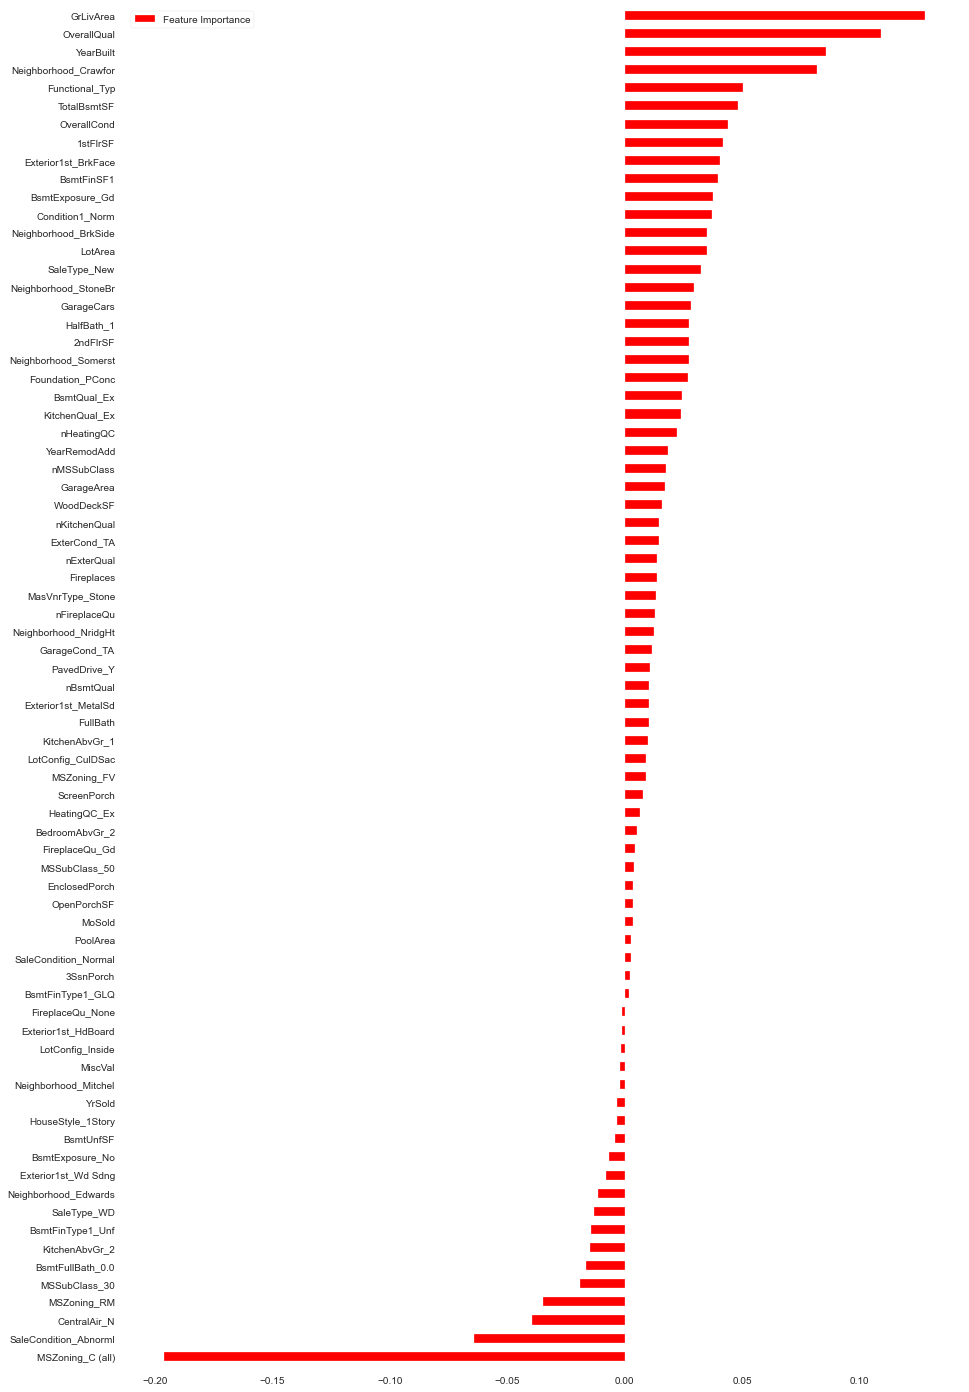

In [17]:
# 用lasso算法分类出相关性强的特征，进行组合
Scaler = RobustScaler()
X2 = df2[:train_data.shape[0]]       #1456*381
X2_test = df2[train_data.shape[0]:]  #1463*381
X2_scaled = Scaler.fit_transform(X2) 
y2_price = train_data['SalePrice']

lasso = Lasso(alpha=0.001)
lasso.fit(X2_scaled, y2_price)
IM_lasso = pd.DataFrame({'Feature Importance': lasso.coef_}, index=df2.columns)
#可视化
IM_lasso[IM_lasso['Feature Importance'] != 0].sort_values('Feature Importance').plot(kind='barh', figsize=(15, 25),color='r')
plt.show()

## 2.3特征组合

为了更好地预测出价格，仍需要更多的特征对住宅进行描述。

这一步使总特征数量变成了403个

In [18]:
#为了更好地预测出价格，仍需要更多的特征对住宅进行描述
df['HasWoodDeck'] = (df['WoodDeckSF'] == 0) * 1
df['HasOpenPorch'] = (df['OpenPorchSF'] == 0) * 1
df['HasEnclosedPorch'] = (df['EnclosedPorch'] == 0) * 1
df['Has3SsnPorch'] = (df['3SsnPorch'] == 0) * 1
df['HasScreenPorch'] = (df['ScreenPorch'] == 0) * 1
df['Haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['Has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['Hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['Hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['Hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

df['TotalHouseArea'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']  
df['TotalArea'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['GarageArea']
df['TotalHouseArea_OverallQual'] = df['TotalHouseArea'] * df['OverallQual']
df['GrLivArea_OverallQual'] = df['GrLivArea'] * df['OverallQual']

df['BsmtFinSF1_OverallQual'] = df['BsmtFinSF1'] * df['OverallQual']

df['LotArea_OverallQual'] = df['LotArea'] * df['OverallQual']
df['TotalHouseArea_LotArea'] = df['TotalHouseArea'] + df['LotArea']
df['nCondition1_TotalHouseArea'] = df['nCondition1'] * df['TotalHouseArea']
df['nCondition1_OverallQual'] = df['nCondition1'] + df['OverallQual']

df['Bsmt'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['BsmtUnfSF']
df['Rooms'] = df['FullBath'] + df['TotRmsAbvGrd']
df['PorchArea'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
df['TotalPlace'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['GarageArea'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']


In [19]:
df_numeric = df.select_dtypes(exclude=['object'])
skewness = df_numeric.apply(lambda x: skew(x.dropna()))
skewness_features = skewness[abs(skewness) > 1].index
df[skewness_features] = np.log1p(df[skewness_features])
df = pd.get_dummies(df)
# 在过程中可能会产生极大或极小值，使用中位数填充
cols = df.columns.values.tolist()
for col in cols:
    df[col].values[np.isinf(df[col].values)] = df[col].median()

df.shape
del cols, col

In [20]:
df.shape

(2915, 403)

In [21]:
df1 = df.copy()

# 3、PCA降维

In [22]:
#去相关性,和标准化
from sklearn.decomposition import PCA, KernelPCA
Scaler = RobustScaler()
X = df1[:train_data.shape[0]]
test_X = df1[train_data.shape[0]:]

X_scaled = Scaler.fit(X).transform(X)
y_price = train_data['SalePrice']
test_X_scaled = Scaler.transform(test_X)

pca = PCA(n_components=320)
X_scaled = pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)
X_scaled.shape, test_X_scaled.shape

((1456, 320), (1459, 320))

# 4、SVR

svr重要参数：C：惩罚因子 C值大时对误差分类的惩罚增大（容易过拟合），C值小时对误差分类的惩罚减小；

kernel：内核类型，’rbf’，’linear’，’poly’等

gamma：’rbf’，’poly’和’sigmoid’的核系数且gamma的值必须大于0；随着gamma的增大，存在对于测试集分类效果差而对训练分类效果好的情况，并且容易泛化误差出现过拟合

epsilon：它指定了epsilon-tube，其中训练损失函数中没有惩罚与在实际值的距离epsilon内预测的点

In [23]:
# 导入算法库
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR
import matplotlib.pyplot as plt
from time import time
import datetime

# 拆分数据
train_X = X_scaled
train_y = y_price
test_x = test_X_scaled
# 折叠数
kf = KFold(n_splits=5, random_state=42, shuffle=True)

### 4.1gridSearchCV网格搜索调参

GridSearchCV：它存在的意义就是自动调参，只要把参数输进去，就能给出最优化的结果和参数。但是这个方法适合于小数据集（适合本次数据集1456）

In [24]:
class grid():
    def __init__(self, model):
        self.model = model

    def grid_get(self, X, y, param_grid):
        grid_search = GridSearchCV(self.model, param_grid, cv=kf, scoring='neg_mean_squared_error',n_jobs=-1)
        grid_search.fit(X, y)
        print('最优参数',grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        print("--------------------------------------------------------------------------------")
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']])
        return grid_search
    
svr = grid(SVR()).grid_get(train_X, train_y, {'C': range(5,15,1), 
                                                    'kernel': ['rbf'], 
                                                    'gamma': np.logspace(-10,0,10),
                                                    'epsilon': np.linspace(0,0.01,10)})

最优参数 {'C': 14, 'epsilon': 0.01, 'gamma': 0.0004641588833612782, 'kernel': 'rbf'} 0.11017779312636669
--------------------------------------------------------------------------------
                                                params  mean_test_score  \
0    {'C': 5, 'epsilon': 0.0, 'gamma': 1e-10, 'kern...         0.397381   
1    {'C': 5, 'epsilon': 0.0, 'gamma': 1.2915496650...         0.397266   
2    {'C': 5, 'epsilon': 0.0, 'gamma': 1.6681005372...         0.395750   
3    {'C': 5, 'epsilon': 0.0, 'gamma': 2.1544346900...         0.377438   
4    {'C': 5, 'epsilon': 0.0, 'gamma': 2.7825594022...         0.209800   
..                                                 ...              ...   
995  {'C': 14, 'epsilon': 0.01, 'gamma': 3.59381366...         0.116935   
996  {'C': 14, 'epsilon': 0.01, 'gamma': 0.00046415...         0.110178   
997  {'C': 14, 'epsilon': 0.01, 'gamma': 0.00599484...         0.121219   
998  {'C': 14, 'epsilon': 0.01, 'gamma': 0.07742636...         0.251

In [28]:
svr = SVR(gamma=0.0004641588833612782, kernel='rbf', C=14, epsilon=0.01)
svr.fit(train_X, train_y)
pred = np.exp(svr.predict(test_x))

In [29]:
result = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': pred})
result.to_csv('smine.csv', index=False)

In [30]:
result

,Id,SalePrice
0,1461,121016.897835
1,1462,165603.788424
2,1463,192141.171618
3,1464,200362.860200
4,1465,189416.319131
...,...,...
1454,2915,87497.059687
1455,2916,79877.591842
1456,2917,174767.713772
1457,2918,124209.379194
